In [1]:
from tensorflow.python.ops import control_flow_util
control_flow_util.ENABLE_CONTROL_FLOW_V2 = True

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
#mpl.rcParams['figure.figsize'] = (10,10)
#mpl.rcParams['axes.grid'] = False
%matplotlib inline
import numpy as np
from PIL import Image
import time
import functools
import IPython

In [3]:
import tensorflow as tf
from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K
import tensorflow.contrib.eager as tfe

In [4]:
# Only run on tf 1.x
if (tf.__version__ == '1.13.1'):
    tf.enable_eager_execution()

In [5]:
tf.__version__

'1.13.1'

In [6]:
content_path = 'japanese_garden.jpg'
style_path = 'picasso_selfportrait.jpg'

In [7]:
tf.executing_eagerly() 

True

## Visualizing the input using pyplot

### <u>Creating an abstracted interface to easily output the image</u>

In [8]:
def load_img(path_to_img):
  max_dim = 512
  img = Image.open(path_to_img)
  long = max(img.size)
  scale = max_dim/long #Scaling image to fit the model and the visualizations
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
  img = kp_image.img_to_array(img)
  
  # We need to broadcast the image array such that it has a batch dimension 
  img = np.expand_dims(img, axis=0)
  return img

In [9]:
def imshow(img, title=None):
  # Remove the batch dimension
  out = np.squeeze(img, axis=0)
  # Normalize for display 
  out = out.astype('uint8')
  plt.imshow(out)
  if title is not None:
    plt.title(title)
  plt.imshow(out)

### <u>Images used</u>

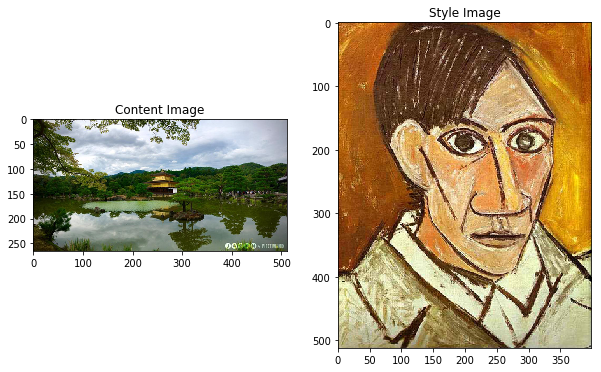

In [13]:
plt.figure(figsize=(10,10))

content = load_img(content_path).astype('uint8')
style = load_img(style_path).astype('uint8')

plt.subplot(1, 2, 1)
imshow(content, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style, 'Style Image')
plt.show()

## Preprocessing the Data

Creating methods to simplify the preprocessing of our data.

In order to get both the content and style representations of our image, we will look at some intermediate layers within our model. <u>Intermediate layers represent feature maps that become increasingly higher ordered as you go deeper.</u> These intermediate layers will define the representation of content and style from our images. For an input image, we will try to match the corresponding style and content target representations at these intermediate layers.

In this case, we are using the network architecture VGG19 in order to save processing time & resources. most of the preprocessing will happen with the tf.keras module:
```python
img = tf.keras.applications.vgg19.preprocess_input(img)
```

In [20]:
def load_and_process_img(path_to_img):
    img = load_img(path_to_img)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img

In [21]:
def showpro(path_to_img):
    img = load_img(path_to_img).astype('uint8')
    img1 = load_and_process_img(path_to_img)
    plt.figure(figsize=(10,10))
    plt.subplot(1, 2, 1)
    imshow(img, 'Original Image')

    plt.subplot(1, 2, 2)
    imshow(img1, 'Processed Image')
    plt.show()

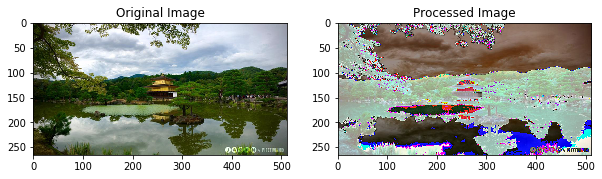

In [22]:
showpro(content_path)

In order to view the outputs of our optimization, we are required to perform the inverse preprocessing step. Furthermore, since our optimized image may take its values anywhere between $- \infty$ and $\infty$, we must clip to maintain our values from within the 0-255 range.

In [23]:
def deprocess_img(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    #Error Checking
    assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")

    # perform the inverse of the preprocessiing step
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]

    x = np.clip(x, 0, 255).astype('uint8')
    return x

## Creating the Model

We use **Intermediate Layer** in our model to map out the content and style features into the pre-trained VGG19 model 

- ### Content Layer
I'm using the <u>'block5_conv2'</u> layer for content as in a ConvNet the deeper layers usually capture the higher features

- ### Style Layer
I'm using the following layers for style as in a ConvNet the earlier layers usually capture the low level features.:
    - block1_conv1
    - block2_conv1
    - block3_conv1
    - block4_conv1
    - block5_conv1


In [24]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2','block4_conv2','block4_conv3'] 

# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [25]:
print("num_content_layers:",num_content_layers,"\nnum_style_layers:",num_style_layers)

num_content_layers: 3 
num_style_layers: 5


In [26]:
def get_model():
    # Load our model. We load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    
    # Get output layers corresponding to style and content layers 
    style_outputs = [vgg.get_layer(name).output for name in style_layers]
    content_outputs = [vgg.get_layer(name).output for name in content_layers]
    model_outputs = style_outputs + content_outputs
    # Build model 
    return models.Model(vgg.input, model_outputs,name="Stylish")

In [27]:
model = get_model()

Instructions for updating:
Colocations handled automatically by placer.


In [28]:
## Model Summary will show all layers
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

## Creating the Custom Loss Funtion for style transfer

- ### <u>Content Loss Function:</u>

Let $C_{nn}$ be a pre-trained deep convolutional neural network. Let $X$ be any image, then $C_{nn}(X)$ is the network fed by X. Let $F^l_{ij}(x) \in C_{nn}(x)$ and $P^l_{ij}(p) \in C_{nn}(p)$ describe the respective intermediate feature representation of the network with inputs $x$ and $p$ at layer $l$. Then we describe the content distance (loss) formally as:

$$L^l_{content}(p, x) = \sum_{i, j} (F^l_{ij}(x) - P^l_{ij}(p))^2$$


In [29]:
def content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

- ### <u>Style Loss Function:</u>

For the style loss we compare the Gram matrices of the two outputs.
The contribution of each layer to the total style loss is described by:

$$E_l = \frac{1}{4N_l^2M_l^2} \sum_{i,j}(G^l_{ij} - A^l_{ij})^2$$

where $G^l_{ij}$ and $A^l_{ij}$ are the respective style representation in layer $l$ of $x$ and $a$. $N_l$ describes the number of feature maps, each of size $M_l = height * width$. Thus, the total style loss across each layer is $$L_{style}(a, x) = \sum_{l \in L} w_l E_l$$

In [30]:
def gram_matrix(input_tensor):
    # We make the image channels first 
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

def style_loss(base_style, gram_target):
    """Expects two images of dimension h, w, c"""
    # height, width, num filters of each layer
    # We scale the loss at a given layer by the size of the feature map and the number of filters
    height, width, channels = base_style.get_shape().as_list()
    gram_style = gram_matrix(base_style)
    return tf.reduce_mean(tf.square(gram_style - gram_target))# / (4. * (channels ** 2) * (width * height) ** 2)

## Applying style transfer to our images

In [31]:
def get_feature_representations(model, content_path, style_path):
    """Helper function to compute our content and style feature representations.
    """
    # Load our images in 
    content_image = load_and_process_img(content_path)
    style_image = load_and_process_img(style_path)

    # batch compute content and style features
    style_outputs = model(style_image)
    content_outputs = model(content_image)


    # Get the style and content feature representations from our model  
    style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
    content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
    return style_features, content_features

In [32]:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
    style_weight, content_weight = loss_weights

    # Feed our init image through our model. This will give us the content and 
    # style representations at our desired layers. Since we're using eager
    # our model is callable just like any other function!
    model_outputs = model(init_image)

    style_output_features = model_outputs[:num_style_layers]
    content_output_features = model_outputs[num_style_layers:]

    style_score = 0
    content_score = 0

    # Accumulate style losses from all layers
    # Here, we equally weight each contribution of each loss layer
    weight_per_style_layer = 1.0 / float(num_style_layers)
    for target_style, comb_style in zip(gram_style_features, style_output_features):
        style_score += weight_per_style_layer * style_loss(comb_style[0], target_style)

    # Accumulate content losses from all layers 
    weight_per_content_layer = 1.0 / float(num_content_layers)
    for target_content, comb_content in zip(content_features, content_output_features):
        content_score += weight_per_content_layer* content_loss(comb_content[0], target_content)

    style_score *= style_weight
    content_score *= content_weight

    # Get total loss
    loss = style_score + content_score 
    return loss, style_score, content_score

In [33]:
def compute_grads(cfg):
    with tf.GradientTape() as tape: 
        all_loss = compute_loss(**cfg)
    # Compute gradients wrt input image
    total_loss = all_loss[0]
    return tape.gradient(total_loss, cfg['init_image']), all_loss

## Creating Training Function

In [36]:
def run_style_transfer(content_path, 
                       style_path,
                       num_iterations=1000,
                       content_weight=1e3, 
                       style_weight=1e-2
                      ): 
    # We don't need to (or want to) train any layers of our model, so we set their
    # trainable to false. 
    tf.executing_eagerly() 
    model = get_model() 
    for layer in model.layers:
        layer.trainable = False

    # Get the style and content feature representations (from our specified intermediate layers) 
    style_features, content_features = get_feature_representations(model, content_path, style_path)
    gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

    # Set initial image
    init_image = load_and_process_img(content_path)
    init_image = tf.Variable(init_image, dtype=tf.float32)
    # Create our optimizer
    if (tf.__version__ == '1.13.1'):
        opt = tf.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)
    else:
        opt = tf.keras.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)

    # For displaying intermediate images 
    iter_count = 1

    # Store our best result
    best_loss, best_img = float('inf'), None

    # Create a nice config 
    loss_weights = (style_weight, content_weight)
    cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
    }
    
    # For displaying
    display_interval = 10
    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means   
    for i in range(num_iterations):
        grads, all_loss = compute_grads(cfg)
        loss, style_score, content_score = all_loss
        opt.apply_gradients([(grads, init_image)])
        clipped = tf.clip_by_value(init_image, min_vals, max_vals)
        init_image.assign(clipped)
        end_time = time.time() 
        print("=",end=" ")
        
        if loss < best_loss:
            # Update best loss and best image from total loss. 
            best_loss = loss
            best_img = init_image

        if i % display_interval== 0:
            print(']\nIteration: {}'.format(i))        
            print('Total loss: {:.4f}, ' 
                'style loss: {:.4f}, '
                'content loss: {:.4f},\n[='.format(loss, style_score, content_score),end=" ")

    return best_img, best_loss

In [38]:
best, best_loss = run_style_transfer(content_path, style_path, num_iterations=150)

= ]
Iteration: 0
Total loss: 297977184.0000, style loss: 297977184.0000, content loss: 0.0000,
[= = = = = = = = = = = ]
Iteration: 10
Total loss: 147656672.0000, style loss: 54582768.0000, content loss: 93073912.0000,
[= = = = = = = = = = = ]
Iteration: 20
Total loss: 130626880.0000, style loss: 42840776.0000, content loss: 87786104.0000,
[= = = = = = = = = = = ]
Iteration: 30
Total loss: 121521416.0000, style loss: 37819528.0000, content loss: 83701888.0000,
[= = = = = = = = = = = ]
Iteration: 40
Total loss: 115799984.0000, style loss: 35200080.0000, content loss: 80599904.0000,
[= = = = = = = = = = = ]
Iteration: 50
Total loss: 111235032.0000, style loss: 33175174.0000, content loss: 78059856.0000,
[= = = = = = = = = = = ]
Iteration: 60
Total loss: 107817720.0000, style loss: 32003558.0000, content loss: 75814160.0000,
[= = = = = = = = = = = ]
Iteration: 70
Total loss: 105135952.0000, style loss: 31242500.0000, content loss: 73893448.0000,
[= = = = = = = = = = = ]
Iteration: 80
Total

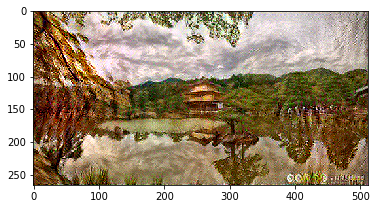

In [39]:
# Use the .numpy() method to get the concrete numpy array
plot_img = best.numpy()
plot_img = deprocess_img(plot_img)
plt.imshow(plot_img)

In [40]:
result = Image.fromarray(plot_img)
size = Image.open(content_path).size
result.thumbnail(size, Image.ANTIALIAS)
result.save('out.jpeg',"JPEG")